In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import cvxpy as cvp
from CSSS import CSSS
import time 
#import cvxopt as co
%matplotlib inline

Import the data and drop rows with NAN.

In [2]:
df=pd.read_csv('input_data.csv')
df=df.dropna()

# Reset index of power-data df to datetime
df['Time'] = pd.to_datetime(df['Unnamed: 0'])
df = df.reset_index().set_index('Time')


# Combine solar radiation data from the airport data with the main dataframe

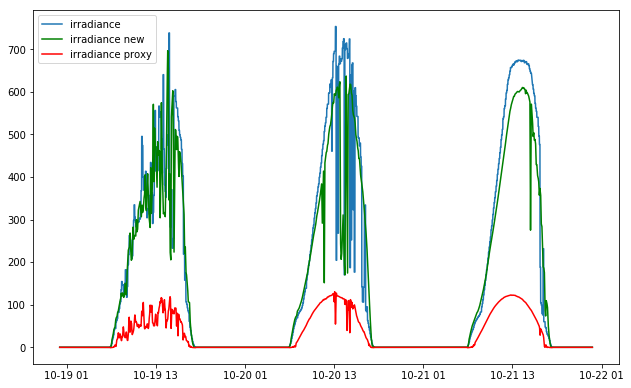

In [5]:
# Load airport solar irradiance data and append days -> put in df2/df3
df2a=pd.read_csv('airport_solar_radiance_19.csv')
df2b=pd.read_csv('airport_solar_radiance_20.csv')
df2c=pd.read_csv('airport_solar_radiance_21.csv')
df2 = df2a.append([df2b, df2c])

# Reset df3 index to datetime
df2['Time'] = pd.to_datetime(df2['Time'])
df3 = df2.reset_index().set_index('Time')

# Upsample df3 to 1 minute and interpolate
df3 = df3.resample('1T').interpolate()

# Append solar irradiance df3 with power-data df --> df
df['Irradiance_new'] = pd.Series(df3['SolarRadiationWatts/m^2'])
# print(df3[400:500])
# print(df[400:500])

plt.plot(df['Irradiance'],label='irradiance')
plt.plot(df['Irradiance_new'],'-g',label='irradiance new')
plt.plot(df['IrradianceProxy'],'-r',label='irradiance proxy')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10.5, 6.5)
plt.show()



# Perform disaggregation with time-varying regressors

In [6]:
## Organises X data from df in appropriate matrix form (Xhat) to support optimization with time-varying regressors
# The function assumes the the regressors are of the form Y_i = X_i * k_i + R_i, where k_i and R_i are scalars and i indicates one time window
# Matrix notation for all time windows: Y = Xhat * [R; k]. Structure of Xhat = [blkdiag(ones_vectors) | blkdiag(Xaux)]

def buildMat(df,Nstd,dfName,normFact,windH):
    N=len(df)
    numD = (np.ceil(np.divide(N,Nstd))).astype(np.int64) # number of days in dataset
    X = np.array(df[dfName]/normFact) # vector data to organize in appropriate form
    numW = len(windH) # number of windows
    Xbig = [[[] for i in range(numW)] for j in range(numD)]

    # Loop through X vector and create Xbig matrix
    initStep = pd.to_datetime(df['Unnamed: 0'].iloc[0])
    initDay = initStep.day

    for i in range(N):
        curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
        curDay = curStep.day - initDay
        curHour = curStep.hour

        indices = np.where(curHour-np.array(windH)>=0)
        curWind = indices[0][len(indices[0])-1]

        Xbig[curDay][curWind].append(X[i])

    # Build Xhat matrix (which multiplies the vector of time-varying regressors) using Xbig
    for i in range(numD):
        Xaux = []
        for j in range(numW):
            tmp = np.array(Xbig[i][j]) 
            tmplen = len(tmp)
            tba = tmp.reshape((tmplen,1)) # to be added
            if j==0:
                Xaux = tba
                Iaux = np.ones((tmplen,1))
            else:       
                Xaux = sc.linalg.block_diag(Xaux,tba)
                Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
        if i==0:
            Xtilda = Xaux
            Itilda = Iaux
        else:
            Xtilda = np.vstack((Xtilda,Xaux))
            Itilda = np.vstack((Itilda,Iaux))
    Xhat = np.hstack((Itilda,Xtilda))
    return Xhat


In [10]:
# Feeder-level Solar Disagg Using the New Class & formulation for time-varying regressors
N=len(df)
Qhat = buildMat(df,1440.0,'Reactive_Power_Total',1000,[0,6,12,18])
# Qhat = buildMat(df,1440.0,'Reactive_Power_Total',1000,[0])
Irhat = buildMat(df,1440.0,'IrradianceProxy',1,[0,6,12,18])
# Irhat = buildMat(df,1440.0,'IrradianceProxy',1,[0]) # using [0] as a window is actually simulating without any window
# Irhat = buildMat(df,1440.0,'Irradiance',1,[0])
# Irhat = buildMat(df,1440.0,'Irradiance_new',1,[0])
# Irhat = np.array(df['IrradianceProxy'])
# Irhat = np.array(df['Irradiance'])
# Irhat = np.array(df['Irradiance_new'])

CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(Qhat, alpha = 15.67, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=10,regularizeSource='diff_l2',gamma=500)  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(Irhat, alpha = 1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )
# Constraint Solar to be 0, when solar proxy is 0
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )

start=time.time()
a=CSSS_solar.constructSolve('ECOS',True,500)
print("It took {} seconds in centralized CSSS".format(time.time()-start))
print(CSSS_solar.models['Solar']['theta'].value)
print(CSSS_solar.models['Load']['theta'].value)
    


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +3e+09  4e-01  8e-05  1e+00  3e+05    ---    ---    1  1  - |  -  - 
 1  -4.151e+06  -4.149e+06  +9e+08  9e-02  3e-05  2e+03  1e+05  0.6938  1e-02   2  2  2 |  0  0
 2  -3.760e+06  -3.758e+06  +3e+08  2e-02  1e-05  2e+03  4e+04  0.6278  2e-02   3  2  2 |  0  0
 3  -1.143e+06  -1.142e+06  +6e+07  3e-03  2e-06  6e+02  7e+03  0.8226  6e-03   3  2  2 |  0  0
 4  -2.165e+06  -2.165e+06  +5e+07  1e-03  2e-06  9e+02  6e+03  0.2218  3e-01   3  3  2 |  0  0
 5  -2.671e+06  -2.670e+06  +5e+07  1e-03  2e-06  1e+03  6e+03  0.0356  8e-01   3  3  3 |  0  0
 6  -3.854e+06  -3.853e+06  +5e+07  7e-04  2e-06  2e+03  6e+03  0.1456  5e-01   3  3  3 |  0  0
 7  -6.322e+06  -6.320e+06  +4e+07  5e-04  2e-06  3e+03  5e+03  0.2592  6e-01   3  3  3 |  0  0
 8  -8.145e+06  -8.142e+06  +4e+07  5e-04  2e-

[[-5.83419491e-11]
 [-5.84031220e-11]
 [-5.82900999e-11]
 ...
 [-5.84214966e-11]
 [-5.84065699e-11]
 [-5.84166295e-11]]


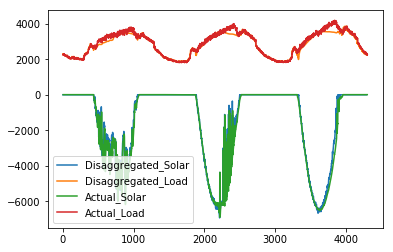

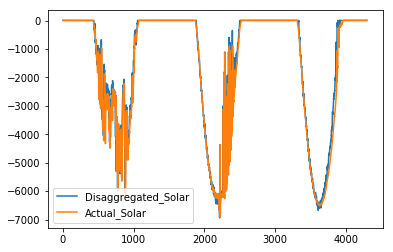

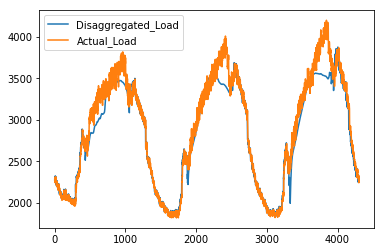

[85.3903637895976, 85.3903637895976, 85.3903637895976]


In [11]:
print(CSSS_solar.models['Solar']['source'].value)
plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')

plt.plot(df['index'],-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
plt.plot(df['index'], df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')

plt.legend()
plt.show()


plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(df['index'],-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')

plt.legend()
plt.show()


plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(df['index'],df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')

plt.legend()
plt.show()


N = len(df)
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
solarDisag = []
for val in CSSS_solar.models['Solar']['source'].value:
    solarDisag.append(float(val))
loadDisag = []
for val in CSSS_solar.models['Load']['source'].value:
    loadDisag.append(float(val))

MAE = (np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N)
MAE1 = (np.sum(np.absolute(solarDisag-np.array(solarAct))))/(N)
MAE2 = (np.sum(np.absolute(loadDisag-np.array(loadAct))))/(N)

print([MAE, MAE1, MAE2])
